In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

import re
import spacy
from nltk import tokenize
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from collections import Counter, defaultdict

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Import the dataset

In [2]:
data_import=pd.read_csv('Twitter-sentiment-self-drive-DFE.csv',header=0,encoding='unicode_escape')

In [3]:
data=pd.DataFrame(data_import)

In [4]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...


# Data Preprocessing

In [5]:
# Drop columns: unit_state, sentiment_gold, sentiment_gold_reasonfields
data.drop(columns=['_unit_state','sentiment_gold','sentiment_gold_reason'],inplace=True)

In [6]:
data.shape

(7156, 8)

In [7]:
data.head()

,_unit_id,_golden,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,text
0,724227031,True,236,NaN,5,0.7579,10001,Two places I'd invest all my money if I could:...
1,724227032,True,231,NaN,5,0.8775,10002,Awesome! Google driverless cars will help the ...
2,724227033,True,233,NaN,2,0.6805,10003,If Google maps can't keep up with road constru...
3,724227034,True,240,NaN,2,0.8820,10004,Autonomous cars seem way overhyped given the t...
4,724227035,True,240,NaN,3,1.0000,10005,Just saw Google self-driving car on I-34. It w...


## Summary Statistics

In [8]:
data.describe()

,_unit_id,_trusted_judgments,sentiment:confidence,our_id
count,7.156000e+03,7156.000000,7156.000000,7156.000000
mean,7.243474e+08,5.834405,0.774654,3609.930548
std,2.506742e+05,11.144930,0.205363,2140.401611
min,7.242270e+08,1.000000,0.248000,1.000000
25%,7.243229e+08,3.000000,0.630600,1789.750000
50%,7.243247e+08,4.000000,0.753100,3578.500000
75%,7.243265e+08,8.000000,1.000000,5367.250000
max,7.269423e+08,241.000000,1.000000,10077.000000


### Check NaN values

In [9]:
# Null values check
data.isnull().sum()/len(data)

_unit_id                0.00000
_golden                 0.00000
_trusted_judgments      0.00000
_last_judgment_at       0.01076
sentiment               0.00000
sentiment:confidence    0.00000
our_id                  0.00000
text                    0.00000
dtype: float64

In [10]:
# Since there is 1% data in '_last_judgment_at' column is null, delete them
data=data[data['_last_judgment_at'].isnull()==False]

### Plot histogram to check the distributions of numeric values and check the outliers

In [11]:
# sentiment
data.groupby(['sentiment']).size()

sentiment
1                103
2                673
3               4225
4               1435
5                443
not_relevant     200
dtype: int64

In [12]:
# not_revelant is not useful in this project, so delete these data
data=data[data['sentiment']!='not_relevant']

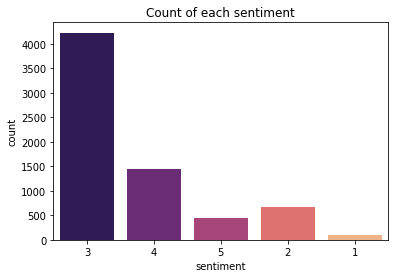

In [13]:
# create count plot
sns.countplot(x=data['sentiment'], palette = 'magma')
plt.title('Count of each sentiment')
plt.show()

1 refers to extremely negative, 5 refers to extremely positive
From the result we can see most reviews are neutral, and positive reviews are more than negative reviews

In [14]:
# _trusted_judgments
data.loc[:,'_trusted_judgments']=pd.to_numeric(data['_trusted_judgments'])

In [15]:
data.groupby('_trusted_judgments').size()

_trusted_judgments
3    2772
4    1830
6      13
7     374
8    1890
dtype: int64

From the reuslt we can see '_trusted_judgments' is ordinal data, use count plot to visulize this variable

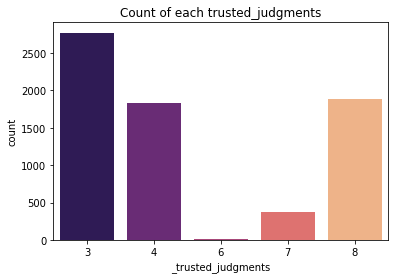

In [16]:
# create count plot
sns.countplot(x=data['_trusted_judgments'], palette = 'magma')
plt.title('Count of each trusted_judgments')
plt.show()

Text(0.5, 1.0, 'frequency of sentiment confidence')

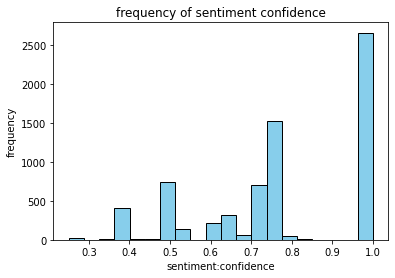

In [17]:
# sentiment:confidence
plt.hist(data['sentiment:confidence'],bins=20,color="skyblue",edgecolor='black')
plt.xlabel('sentiment:confidence')
plt.ylabel('frequency')
plt.title('frequency of sentiment confidence')

In [18]:
# delete the duplicates
data=data.drop_duplicates()

# Tokenize and clean the text data

### Data Cleaning

In [19]:
# load the package
nlp = spacy.load("en_core_web_sm")

In [20]:
# delete the stop words and words whose lenth is 1
tweets=data['text'].to_numpy()
cleaned_tweets=[]
t_tokenizer=TweetTokenizer()
for tw in tweets:
    cleaned=[word for word in t_tokenizer.tokenize(tw.lower()) if word not in nlp.Defaults.stop_words and len(word)>2]
    cleaned_tweets.append(' '.join(cleaned))
    
# Reference: 
# Slides of course: Making Product Count, Data Science for Product Management, Session 7

In [21]:
# Delete the URL
def delete_URL(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data
# Reference:
# https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

In [22]:
no_URL_tweets=[]
for tweet in cleaned_tweets:
    no_URL_tweets.append(delete_URL(tweet))

In [23]:
# Delete useless words like 'self', 'driving', 'cars', from which we cannot tell the sentiment
delete_features=['self','driving','cars','car','google','...','ââå','drive','driver','i','vehicle','driver',
                'vehicles','its','self-driving','driverless','idea' 'googles','street','audi','nt','ca']

final_tweets=[]
final_tokenizer=TweetTokenizer()

for tw in no_URL_tweets:
    cleaned=[word for word in final_tokenizer.tokenize(tw.lower()) if word not in delete_features]
    final_tweets.append(' '.join(cleaned))

### Most common words

In [25]:
# Overall
overall=[]
for tw in final_tweets:
    for token in nlp(tw.lower()):
        if len(token.text)>1 and token.text not in delete_features:
            overall.append(token.text)
overall_counter=Counter(overall)
overall_sort = overall_counter.most_common()

In [27]:
data1=pd.DataFrame(overall_sort)
data1.columns=['word','count']

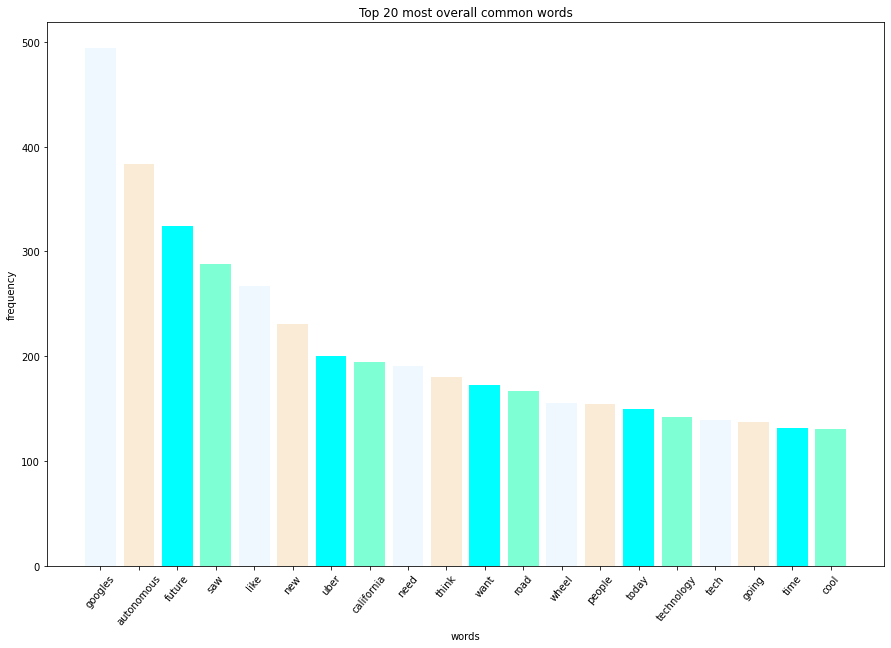

In [28]:
# visualize top 20 most common words over all
plt.figure(figsize=(15,10))
color_backup = ['aliceblue','antiquewhite','aqua','aquamarine'] 
plt.bar(data1['word'][:20],data1['count'][:20],color=color_backup)
plt.xticks(rotation=50)
plt.xlabel("words")
plt.ylabel("frequency")
plt.title('Top 20 most overall common words')
plt.show()

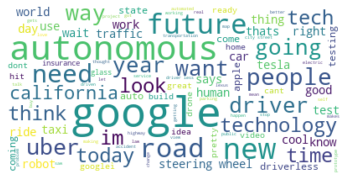

In [29]:
# Use wordcloud to visualize the words with frequency
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(''.join(final_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Reference: Datacamp
# https://www.datacamp.com/community/tutorials/wordcloud-python

In [31]:
# get most common adj, verb, nouns, punctuation respetively
adjs=[]
nouns=[]
verbs=[]
puncs=[]
for tw in final_tweets:
    for token in nlp(tw.lower()):
        if len(token.text)>1 and token.text not in delete_features:
            if token.pos_=='ADJ':
                adjs.append(token.text)
            elif token.pos_=='NOUN':
                nouns.append(token.text)
            elif token.pos_=='VERB':
                verbs.append(token.text)
            elif token.text in string.punctuation:
                puncs.append(token.text)
        else:
            continue

adjs_counter=Counter(adjs)
nouns_counter=Counter(nouns)
verbs_counter=Counter(verbs)
puncs_counter=Counter(puncs)



# Reference: 
# Slides of course: Making Product Count, Data Science for Product Management, Session 7

In [32]:
# Top 10 Most common nouns
print(nouns_counter.most_common()[:11])

[('googles', 433), ('uber', 198), ('road', 158), ('people', 154), ('today', 150), ('wheel', 143), ('technology', 140), ('time', 129), ('future', 129), ('drivers', 126), ('tech', 123)]


In [33]:
# Top 10 Most common verbs
print(verbs_counter.most_common()[:11])

[('saw', 280), ('think', 176), ('want', 158), ('need', 126), ('wait', 123), ('says', 121), ('going', 121), ('look', 86), ('coming', 85), ('come', 76), ('know', 70)]


In [34]:
# Top 10 Most common punctuations
print(puncs_counter.most_common()[:11])

[]


In [35]:
# Top 10 Most common adj
print(adjs_counter.most_common()[:11])

[('autonomous', 352), ('new', 206), ('future', 185), ('cool', 95), ('ready', 87), ('good', 83), ('great', 80), ('public', 69), ('legal', 63), ('interesting', 63), ('awesome', 62)]


In [36]:
adj_df=pd.DataFrame(adjs_counter.most_common())
adj_df.columns=['adj word','count']

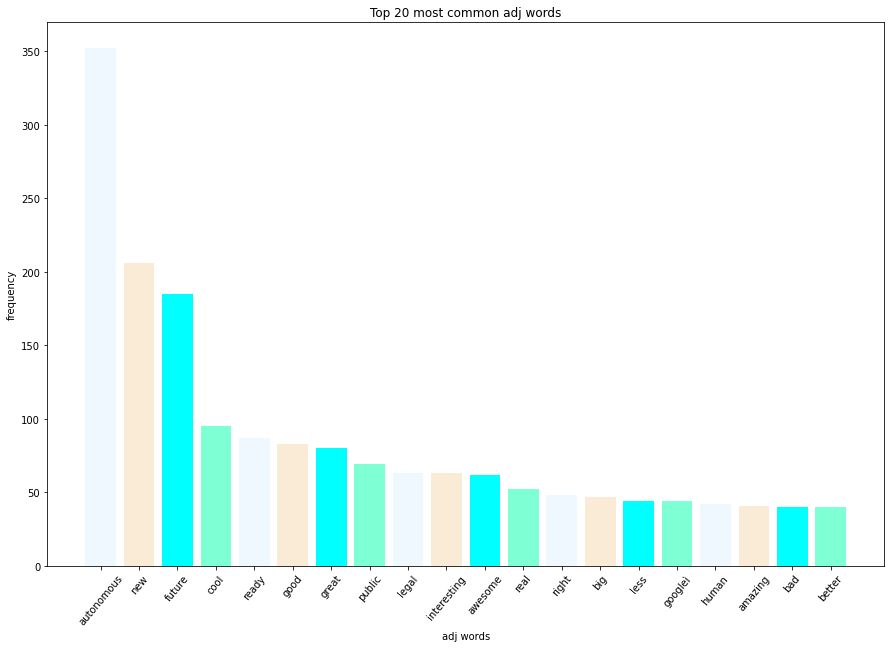

In [37]:
# adj is always highly related to sentiment, thus we chooose to visualize the frequency of common adj
# visualize top 20 most common adj words over all
plt.figure(figsize=(15,10))
color_backup = ['aliceblue','antiquewhite','aqua','aquamarine']
plt.bar(adj_df['adj word'][:20],adj_df['count'][:20],color=color_backup)
plt.xticks(rotation=50)
plt.xlabel("adj words")
plt.ylabel("frequency")
plt.title('Top 20 most common adj words')
plt.show()

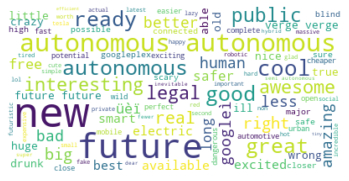

In [38]:
# Use wordcloud to visualize the adj words with frequency
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(','.join(adjs))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Reference: Datacamp
# https://www.datacamp.com/community/tutorials/wordcloud-python

# Predictive modeling for sentiment with 1-5 scale.

### Feature construction

In [39]:
# since adj is strongly related to sentiment, only contain adj to do predictive modelling
adj_final=list(set(adjs))
adj_tweets=[]
for tw in final_tweets:
    cleaned=[word for word in final_tokenizer.tokenize(tw.lower()) if word in adj_final and word not in delete_features]
    adj_tweets.append(' '.join(cleaned))

In [40]:
# Use CountVectorizer to construct features
feature_vectorizer = CountVectorizer()
features = feature_vectorizer.fit_transform(adj_tweets)

# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [41]:
features.shape

(6879, 1133)

### Model: Naive Bayes Multinomial

In [42]:
x_train,x_test, y_train, y_test = train_test_split(features,data['sentiment'],test_size=0.3, random_state=0)
clf = MultinomialNB()
clf.fit(x_train, y_train)

MultinomialNB()

In [43]:
clf.score(x_test, y_test, sample_weight=None)

0.6298449612403101

In [44]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(x_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[   0,    0,   26,    5,    0],
       [   0,    9,  181,   18,    0],
       [   0,    3, 1208,   46,    5],
       [   0,    1,  346,   73,    8],
       [   0,    1,   83,   41,   10]])

### 10 top words/tokens for each sentiment rating

In [45]:
clf.classes_

array(['1', '2', '3', '4', '5'], dtype='<U1')

In [46]:
sentiment1 = clf.feature_log_prob_[0, :].argsort()[::-1]
sentiment2 = clf.feature_log_prob_[1, :].argsort()[::-1]
sentiment3 = clf.feature_log_prob_[2, :].argsort()[::-1]
sentiment4 = clf.feature_log_prob_[3, :].argsort()[::-1]
sentiment5 = clf.feature_log_prob_[4, :].argsort()[::-1]

In [47]:
print('10 top words for sentiment rate 1')
print(np.take(feature_vectorizer.get_feature_names_out(), sentiment1[:10]))
print('\n10 top words for sentiment rate 2')
print(np.take(feature_vectorizer.get_feature_names_out(), sentiment2[:10]))
print('\n10 top words for sentiment rate 3')
print(np.take(feature_vectorizer.get_feature_names_out(), sentiment3[:10]))
print('\n10 top words for sentiment rate 4')
print(np.take(feature_vectorizer.get_feature_names_out(), sentiment4[:10]))
print('\n10 top words for sentiment rate 5')
print(np.take(feature_vectorizer.get_feature_names_out(), sentiment5[:10]))

10 top words for sentiment rate 1
['think' 'fuck' 'autonomous' 'good' 'want' 'like' 'dangerous' 'fucking'
 'wrong' 'future']

10 top words for sentiment rate 2
['like' 'think' 'autonomous' 'new' 'future' 'want' 'great' 'tech' 'major'
 'good']

10 top words for sentiment rate 3
['autonomous' 'future' 'new' 'like' 'think' 'test' 'googleì' 'tech'
 'legal' 'build']

10 top words for sentiment rate 4
['cool' 'want' 'future' 'like' 'autonomous' 'new' 'think' 'good' 'pretty'
 'ready']

10 top words for sentiment rate 5
['want' 'awesome' 'cool' 'future' 'like' 'new' 'googleì' 'autonomous'
 'amazing' 'excited']


From the result, we can see the words in sentiment rate 1 is more likely to be negarive, and positive in sentiment rate 5. 

# Model performance for each rating (1-5)

1. Even we can see some words are negative in sentiment 1 and positive in sentiment 5, but it's not very accurate. In sentiment one, we can see negative words like dangerous and wrong, but we can still see positive words like good. In sentiment 2, it still should be negative sentiment, but we cannot see any negative words in sentiment 2.

2. The dataset is extremely unbalanced,and most reviews are positive or netrual, in this case, the model is more likely to predict the reviews to be postive and that why it's not accurate enough in the top 10 words result for sentiment 1 and 2. To make improvements, upsampling or downsampling are suggested before training the model. 